In [3]:
import numpy as np
from scipy.sparse import coo_matrix, kron, identity, eye, csr_matrix, csc_matrix
from scipy.linalg import expm
from qutip import *
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import warnings
from random import randint
import time
from sklearn.metrics import mean_absolute_error

In [2]:
def global_interactions_model(w1, lam, cn):
    w2 = 1
    Jx = 1
    Jy = 1
    Jz = 0.0
    ts = 0.2
    tss = 0.2
    tse = 0.05

    HS1 = (-w1/2)*tensor(sigmaz(), qeye(2), qeye(2)) #Self Hamiltonian of Spin 1
    HS2 = (-w2/2)*tensor(qeye(2), sigmaz(), qeye(2)) #Self Hamiltonian of Spin 2
    HS1S2 = lam/2*(tensor(sigmax(), sigmax(), qeye(2))) #Interaction Hamiltonian for Spin 1 and Spin 2
    HS1E = (1/2) * (Jx*tensor(sigmax(), qeye(2), sigmax()) + Jy*tensor(sigmay(), qeye(2), sigmay()) + Jz*tensor(sigmaz(), qeye(2), sigmaz()))
    HS2E = (1/2) * (Jx*tensor(qeye(2), sigmax(), sigmax()) + Jy*tensor(qeye(2), sigmay(), sigmay()) + Jz*tensor(qeye(2), sigmaz(), sigmaz()))

    US = csc_matrix(expm(-1j * (HS1 + HS2) * ts))
    US1S2 = csc_matrix(expm(-1j * HS1S2 * tss))
    US1E = csc_matrix(expm(-1j * HS1E * tse))
    US2E = csc_matrix(expm(-1j * HS2E * tse))

    PsiSinitial = coo_matrix(np.kron([[np.cos(np.pi/4)], [np.sin(np.pi/4)]], 
                                     [[np.cos(np.pi/4)], [np.sin(np.pi/4)]]))

    RhoSinitial = PsiSinitial.dot(PsiSinitial.conjugate().transpose())
    rho_Einitial = np.array([[1., 0.], [0., 0.]])

    RhoS1 = [csc_matrix(np.zeros((2, 2))) for _ in range(cn + 1)]
    RhoS2 = [csc_matrix(np.zeros((2, 2))) for _ in range(cn + 1)]
    RhoS1S2 = [csc_matrix(np.zeros((4, 4))) for _ in range(cn + 1)]
    RhoE1E2 = [csc_matrix(np.zeros((4, 4))) for _ in range(cn + 1)]
    rho = [csc_matrix(np.zeros((4, 4))) for _ in range(cn + 1)]

    RhoS1[0] = Qobj(RhoSinitial, dims=[[2, 2], [2, 2]]).ptrace(1)
    RhoS2[0] = Qobj(RhoSinitial, dims=[[2, 2], [2, 2]]).ptrace(0)
    RhoS1S2[0] = RhoSinitial.toarray()
    RhoE1E2[0] = rho_Einitial
    rho[0] = RhoSinitial.toarray()

    for ii in range(cn):
        rho_rho = kron(rho[ii], rho_Einitial)
        rho_C = Qobj(US) * Qobj(US1S2) * Qobj(US2E) * Qobj(US1E) * Qobj(rho_rho) * Qobj(US1E).dag() * Qobj(US2E).dag() * Qobj(US1S2).dag() * Qobj(US).dag()
        rho_Sys1Sys2 = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace([0,1]).data.toarray()
        rho_Sys1 = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace(0).data.toarray()
        rho_Sys2 = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace(1).data.toarray()
        rho_SysEnv = Qobj(rho_C, dims=[[2,2,2], [2,2,2]]).ptrace([0,1]).data.toarray()
        RhoS1[ii+1] = Qobj(rho_Sys1/np.trace(rho_Sys1))
        RhoS2[ii+1] = Qobj(rho_Sys2/np.trace(rho_Sys2))
        RhoS1S2[ii+1] = Qobj(rho_Sys1Sys2/np.trace(rho_Sys1Sys2))
        rho[ii+1] = rho_SysEnv/np.trace(rho_SysEnv)

    ExpecXspin1 = [np.array(np.trace(RhoS1[kk] * sigmax())).astype(float) for kk in range(len(RhoS1))]
    ExpecXspin2 = [np.array(np.trace(RhoS2[jj] * sigmax())).astype(float) for jj in range(len(RhoS2))]
    
    
    return ExpecXspin1, ExpecXspin2

In [3]:
%%time
import time
tempoInicial = time.time()
dataGlobalModel = list()
for i in range(0, 76):
    w1=0.93 + (i/500)
    for j in range(0,51):
        print(i, time.time()-tempoInicial)
        prov = w1 + (randint(-10, 10)*0.0001)
        lam = (j/500) + (randint(-10, 10)*0.0001)
        print(prov, lam)
        ExpecXspin1, ExpecXspin2 = global_interactions_model(w1=prov, lam=lam, cn = 5000)
        dataGlobalModel.append([w1]+[lam]+ ExpecXspin1+ExpecXspin2)
dataGlobalModel = pd.DataFrame(dataGlobalModel)

0 2.1457672119140625e-06
0.9301 0.0001


/var/folders/f4/hx11lq_j6792tcjgw6ymn5kc0000gn/T/ipykernel_69141/2169738663.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  ExpecXspin1 = [np.array(np.trace(RhoS1[kk] * sigmax())).astype(float) for kk in range(len(RhoS1))]
/var/folders/f4/hx11lq_j6792tcjgw6ymn5kc0000gn/T/ipykernel_69141/2169738663.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  ExpecXspin2 = [np.array(np.trace(RhoS2[jj] * sigmax())).astype(float) for jj in range(len(RhoS2))]


0 15.631765127182007
0.9306000000000001 0.0019
0 31.32006025314331
0.9309000000000001 0.0036
0 46.75729727745056
0.9299000000000001 0.005
0 62.41670298576355
0.931 0.009000000000000001
0 78.05871820449829
0.9294 0.0092
0 93.84583020210266
0.9292 0.0126
0 109.52428436279297
0.9309000000000001 0.0148
0 125.92239737510681
0.9291 0.015600000000000001
0 142.33445811271667
0.9298000000000001 0.0172
0 159.23832821846008
0.9301 0.0195
0 175.10584497451782
0.9299000000000001 0.021599999999999998
0 191.72851419448853
0.9308000000000001 0.0233
0 207.79788422584534
0.9302 0.0259
0 223.61675596237183
0.929 0.0276
0 239.5202853679657
0.9309000000000001 0.0292
0 255.25626015663147
0.9294 0.0325
0 272.06180930137634
0.9307000000000001 0.034
0 289.335577249527
0.9295000000000001 0.036
0 308.5463831424713
0.929 0.037
0 325.8434433937073
0.931 0.0398
0 344.5802402496338
0.9296000000000001 0.041100000000000005
0 361.20919704437256
0.9297000000000001 0.0448
0 378.8315043449402
0.9291 0.0453
0 396.421580076

3 3298.771496295929
0.9359000000000001 0.091
3 3315.040562391281
0.937 0.0916
3 3330.9566583633423
0.9364 0.0943
3 3348.9462389945984
0.9359000000000001 0.0951
3 3365.095908164978
0.9365 0.0988
3 3383.244929075241
0.9362 0.10010000000000001
4 3399.653398036957
0.9377000000000001 0.0002
4 3416.720659971237
0.9379000000000001 0.0018
4 3432.9194853305817
0.9387000000000001 0.0035
4 3448.825318336487
0.9373 0.006
4 3464.5887842178345
0.9382 0.0088
4 3480.5959770679474
0.9376000000000001 0.0103
4 3496.3962659835815
0.9373 0.0123
4 3512.29208612442
0.9372 0.0132
4 3528.571380138397
0.9378000000000001 0.016
4 3545.82595205307
0.9390000000000001 0.017699999999999997
4 3562.7099311351776
0.9376000000000001 0.0205
4 3579.3424530029297
0.9376000000000001 0.022
4 3595.906598329544
0.9378000000000001 0.024900000000000002
4 3612.2786140441895
0.9374 0.0266
4 3628.5638489723206
0.9390000000000001 0.027200000000000002
4 3645.6832780838013
0.9373 0.030199999999999998
4 3662.1701362133026
0.937500000000

7 6555.446519136429
0.9442 0.0579
7 6572.645382165909
0.9442 0.061
7 6590.272057294846
0.9443 0.062
7 6607.546140193939
0.9433 0.0644
7 6624.810319185257
0.9436000000000001 0.06620000000000001
7 6643.0742473602295
0.9444 0.0688
7 6660.099388360977
0.9440000000000001 0.069
7 6680.344979286194
0.9433 0.072
7 6697.327454328537
0.9437000000000001 0.07339999999999999
7 6714.095610141754
0.9449000000000001 0.0769
7 6730.7069482803345
0.9446000000000001 0.0784
7 6747.484297990799
0.9439000000000001 0.0805
7 6763.8018572330475
0.9444 0.08170000000000001
7 6780.099527359009
0.9434 0.0833
7 6796.416402339935
0.9434 0.08549999999999999
7 6814.338511228561
0.9432 0.08879999999999999
7 6832.089166164398
0.9446000000000001 0.0906
7 6850.266927242279
0.9437000000000001 0.09129999999999999
7 6868.864480018616
0.9435000000000001 0.0937
7 6885.614077329636
0.9449000000000001 0.0956
7 6902.314800262451
0.9442 0.0988
7 6918.922338247299
0.9435000000000001 0.09960000000000001
8 6936.376865148544
0.9465 0.0

11 9803.321550130844
0.9522 0.0185
11 9821.485476255417
0.9516000000000001 0.020900000000000002
11 9838.758312225342
0.9528000000000001 0.022699999999999998
11 9856.014191150665
0.9516000000000001 0.0247
11 9872.574871063232
0.9516000000000001 0.0258
11 9889.622698068619
0.9529000000000001 0.027800000000000002
11 9906.054479122162
0.9516000000000001 0.0305
11 9922.69148015976
0.9520000000000001 0.032
11 9939.239861011505
0.9520000000000001 0.033800000000000004
11 9956.154642343521
0.9514 0.035699999999999996
11 9973.17062830925
0.9530000000000001 0.038
11 9992.18470621109
0.9525 0.040100000000000004
11 10008.905533313751
0.9527000000000001 0.041100000000000005
11 10027.66324520111
0.9511000000000001 0.043399999999999994
11 10044.540645122528
0.9521000000000001 0.0458
11 10061.450476169586
0.9513 0.0471
11 10078.077388048172
0.9520000000000001 0.05
11 10095.105946302414
0.9510000000000001 0.051199999999999996
11 10111.664308071136
0.9518000000000001 0.054
11 10131.513814210892
0.9513 0.

14 12713.277069091797
0.9571000000000001 0.0589
14 12730.118013381958
0.9577000000000001 0.059199999999999996
14 12746.904288053513
0.9588000000000001 0.0616
14 12763.494761228561
0.9576000000000001 0.0631
14 12780.061732292175
0.9590000000000001 0.06670000000000001
14 12796.509071111679
0.9580000000000001 0.06860000000000001
14 12812.979183197021
0.9586000000000001 0.07010000000000001
14 12829.37599825859
0.9580000000000001 0.072
14 12846.015983104706
0.9574 0.0745
14 12862.549327135086
0.9579000000000001 0.0765
14 12879.288935184479
0.9584 0.0776
14 12895.767978191376
0.9580000000000001 0.0805
14 12912.405143022537
0.9587000000000001 0.08270000000000001
14 12928.76960325241
0.9589000000000001 0.084
14 12945.454870223999
0.9582 0.0862
14 12961.8518242836
0.9576000000000001 0.088
14 12978.654117107391
0.9577000000000001 0.0892
14 12995.181172132492
0.9588000000000001 0.092
14 13011.879018068314
0.9587000000000001 0.0935
14 13028.305092096329
0.9584 0.0951
14 13045.064900159836
0.9584 0

17 15665.471278190613
0.9631000000000001 0.0955
17 15683.215088129044
0.9639000000000001 0.09770000000000001
17 15701.709394216537
0.9633 0.09970000000000001
18 15720.128382205963
0.9653 -0.0008
18 15739.505805253983
0.9652000000000001 0.0010999999999999998
18 15757.924122095108
0.9658000000000001 0.0031
18 15776.599021196365
0.9666000000000001 0.0058000000000000005
18 15793.944784164429
0.9650000000000001 0.0077
18 15812.291501045227
0.9668000000000001 0.0108
18 15829.554692268372
0.9670000000000001 0.0111
18 15847.656777143478
0.9653 0.0146
18 15865.014182329178
0.9666000000000001 0.0151
18 15883.101167201996
0.9670000000000001 0.016999999999999998
18 15900.597816228867
0.9654 0.0201
18 15918.50981926918
0.9656000000000001 0.023
18 15935.751518964767
0.9667000000000001 0.0239
18 15953.782798290253
0.9658000000000001 0.026099999999999998
18 15971.23251414299
0.9651000000000001 0.0281
18 15989.09222316742
0.9654 0.0306
18 16006.479389190674
0.9663 0.032
18 16024.912697076797
0.96550000

21 18716.577611207962
0.9715000000000001 0.0273
21 18734.859594106674
0.9714 0.029099999999999997
21 18753.214854240417
0.9710000000000001 0.0328
21 18771.072567224503
0.9718000000000001 0.0337
21 18789.258085250854
0.9721000000000001 0.037
21 18806.9072971344
0.9723 0.0383
21 18824.98227405548
0.9724 0.040600000000000004
21 18842.349496126175
0.9727000000000001 0.041800000000000004
21 18862.051450252533
0.9722000000000001 0.0436
21 18879.702639102936
0.9725 0.0453
21 18898.926772117615
0.9726000000000001 0.0484
21 18916.083634376526
0.9719000000000001 0.0502
21 18935.412790060043
0.9711000000000001 0.051199999999999996
21 18952.614013195038
0.9727000000000001 0.0533
21 18972.310415267944
0.9720000000000001 0.0562
21 18989.662711143494
0.9716000000000001 0.057
21 19008.85039615631
0.9713 0.0596
21 19026.00116610527
0.9715000000000001 0.0621
21 19044.359287023544
0.9730000000000001 0.0636
21 19061.729602098465
0.9717000000000001 0.0668
21 19079.794280290604
0.9721000000000001 0.0675
21 

24 21889.137355089188
0.9770000000000001 0.0653
24 21907.081857204437
0.9777000000000001 0.06760000000000001
24 21926.911662101746
0.9772000000000001 0.0703
24 21944.579617023468
0.9787000000000001 0.0725
24 21963.663937091827
0.9782000000000001 0.0746
24 21981.83119726181
0.9778000000000001 0.0757
24 22001.842334985733
0.9784 0.0779
24 22019.443451166153
0.9776000000000001 0.0803
24 22039.59474515915
0.9772000000000001 0.08120000000000001
24 22057.004878282547
0.9781000000000001 0.083
24 22077.51272034645
0.9790000000000001 0.08549999999999999
24 22095.715462207794
0.9778000000000001 0.0885
24 22116.34547305107
0.9771000000000001 0.0909
24 22134.575390338898
0.9777000000000001 0.0914
24 22153.918646097183
0.9789000000000001 0.095
24 22172.517044067383
0.9779000000000001 0.0959
24 22191.986413240433
0.9782000000000001 0.0988
24 22210.783915042877
0.9770000000000001 0.0998
25 22229.75516819954
0.9797000000000001 -0.0001
25 22249.017237186432
0.9805 0.0022
25 22267.910049200058
0.9798000

27 25070.39086318016
0.9843000000000001 0.0975
27 25088.833992242813
0.9847000000000001 0.1
28 25108.761099100113
0.9858000000000001 -0.0002
28 25128.484831094742
0.9859000000000001 0.0012000000000000001
28 25147.860941171646
0.9856000000000001 0.0034000000000000002
28 25166.34609723091
0.9869000000000001 0.006500000000000001
28 25185.37191414833
0.9863000000000001 0.0082
28 25204.262501239777
0.9867000000000001 0.009600000000000001
28 25223.81924510002
0.9863000000000001 0.0112
28 25243.51190519333
0.9854 0.0147
28 25262.813814163208
0.9852000000000001 0.0161
28 25282.03064918518
0.9870000000000001 0.0172
28 25300.30586218834
0.9855000000000002 0.0199
28 25319.572661161423
0.9858000000000001 0.022199999999999998
28 25337.46586418152
0.9853000000000001 0.023200000000000002
28 25357.266496181488
0.9869000000000001 0.0252
28 25375.37221121788
0.9862000000000001 0.027800000000000002
28 25393.845405340195
0.9868000000000001 0.031
28 25411.74605703354
0.9868000000000001 0.0319
28 25430.9823

31 28580.709640979767
0.9924 0.0502
31 28599.183042049408
0.9926 0.051699999999999996
31 28616.594701051712
0.9913 0.0548
31 28635.05013036728
0.9924999999999999 0.0558
31 28652.20284819603
0.9915 0.057800000000000004
31 28670.60805416107
0.9927 0.059699999999999996
31 28688.04892706871
0.9929 0.0618
31 28706.559111356735
0.9917 0.06420000000000001
31 28723.763292312622
0.9921 0.0651
31 28742.391011238098
0.9911 0.068
31 28759.662093162537
0.9924999999999999 0.0694
31 28778.1794962883
0.992 0.0726
31 28795.493816137314
0.9914 0.0737
31 28814.831867218018
0.9921 0.0764
31 28832.428567171097
0.9922 0.0789
31 28853.23294520378
0.9928 0.0794
31 28871.647099256516
0.9928 0.0813
31 28891.749816179276
0.9926 0.0844
31 28909.74040222168
0.9923 0.08579999999999999
31 28930.396559238434
0.9928 0.08779999999999999
31 28948.985926151276
0.992 0.09
31 28967.69075512886
0.9911 0.091
31 28985.008682012558
0.993 0.0942
31 29003.264604330063
0.9921 0.0964
31 29020.428455352783
0.9928 0.0975
31 29038.65

35 32673.28922510147
1.0001 0.0618
35 32692.03374528885
1.0003 0.065
35 32712.828486204147
0.9992 0.0653
35 32731.491980075836
1.0001 0.0685
35 32752.45947599411
0.9998 0.07100000000000001
35 32771.14387822151
1.001 0.073
35 32792.511233091354
1.0003 0.0739
35 32811.41993498802
1.0005 0.0764
35 32832.55968904495
1.0005 0.0774
35 32851.394037008286
1.0008 0.0792
35 32872.89974617958
1.0007 0.0814
35 32891.58803319931
1.001 0.0835
35 32913.25460219383
0.9995 0.08639999999999999
35 32931.96524810791
1.0009 0.0885
35 32953.745551109314
0.9991 0.09029999999999999
35 32972.3396961689
0.9994 0.0925
35 32994.3270483017
0.9994 0.0931
35 33012.87965917587
1.001 0.0956
35 33035.10201215744
0.999 0.09820000000000001
35 33054.02210307121
0.9993 0.101
36 33076.29465031624
1.0014 0.0009000000000000001
36 33095.10553431511
1.0014 0.0014
36 33117.37000513077
1.0015 0.0035
36 33136.065759181976
1.0025 0.0068000000000000005
36 33158.56618332863
1.0015 0.0081
36 33177.41435909271
1.0017 0.0090000000000000

39 37093.61771821976
1.0072 0.084
39 37115.312252283096
1.0087 0.0861
39 37134.63594722748
1.0081 0.08779999999999999
39 37156.130917310715
1.0085 0.0905
39 37175.5986931324
1.008 0.0926
39 37197.15405321121
1.0072 0.0941
39 37216.774928331375
1.0087 0.097
39 37238.65615820885
1.0076 0.09770000000000001
39 37258.147148132324
1.008 0.09920000000000001
40 37279.62075924873
1.0108 0.0009000000000000001
40 37298.98341917992
1.0095 0.002
40 37320.46218538284
1.0107 0.0038
40 37339.94883728027
1.0096 0.0068000000000000005
40 37361.84397697449
1.0108 0.0076
40 37381.315598249435
1.0093 0.0098
40 37402.81491923332
1.0106 0.0114
40 37422.32438015938
1.0095 0.0149
40 37443.69261717796
1.0091 0.0152
40 37463.46284818649
1.0099 0.018799999999999997
40 37485.77803015709
1.0090000000000001 0.0204
40 37505.247808218
1.0108 0.022799999999999997
40 37526.53193426132
1.0105 0.024
40 37545.98473215103
1.0090000000000001 0.026099999999999998
40 37567.97182536125
1.0094 0.027
40 37588.37664628029
1.0109 0.

43 41573.14337205887
1.0163 0.0894
43 41594.60871720314
1.0169 0.0911
43 41617.68782019615
1.0157 0.094
43 41639.066412210464
1.0158 0.0968
43 41662.3559691906
1.0166 0.0984
43 41683.54966831207
1.0150000000000001 0.0995
44 41706.68309521675
1.0171000000000001 0.0008
44 41727.90875911713
1.0189 0.0012000000000000001
44 41750.65800333023
1.0176 0.0042
44 41772.24025321007
1.0172 0.007
44 41795.70623421669
1.019 0.008
44 41816.97135210037
1.0188 0.0097
44 41839.84787631035
1.0186 0.0111
44 41861.18542718887
1.0172 0.013000000000000001
44 41884.111562013626
1.0185 0.015300000000000001
44 41905.52118420601
1.0185 0.0184
44 41928.71442627907
1.018 0.0196
44 41950.021834135056
1.0172 0.021099999999999997
44 41973.253499269485
1.019 0.0242
44 41994.838396310806
1.0175 0.026099999999999998
44 42018.059601306915
1.0175 0.0279
44 42039.642030239105
1.0173 0.0299
44 42063.49000620842
1.0176 0.0324
44 42084.685799360275
1.0181 0.0337
44 42107.7767291069
1.0175 0.036699999999999997
44 42128.9489572

48 46360.571803331375
1.0263 0.0017000000000000001
48 46384.55788111687
1.0269 0.0036
48 46406.48429632187
1.0254 0.006
48 46429.84940910339
1.0256 0.0081
48 46451.569857120514
1.027 0.0095
48 46475.19352722168
1.0250000000000001 0.0129
48 46497.52177000046
1.0262 0.014
48 46521.313566207886
1.027 0.0159
48 46543.28196024895
1.0267 0.016999999999999998
48 46567.59297513962
1.0253 0.019
48 46591.09759020805
1.0267 0.021699999999999997
48 46615.53159022331
1.0251000000000001 0.0233
48 46637.65456819534
1.0250000000000001 0.0255
48 46661.712762117386
1.0265 0.029
48 46683.68177318573
1.0253 0.0298
48 46708.03266310692
1.0261 0.0315
48 46730.14286804199
1.0251000000000001 0.0349
48 46754.136213064194
1.0261 0.036899999999999995
48 46776.12480020523
1.0254 0.038
48 46800.05350399017
1.0252000000000001 0.0395
48 46822.39671230316
1.0256 0.041
48 46846.635741233826
1.0265 0.043399999999999994
48 46868.818773031235
1.027 0.0456
48 46892.89320707321
1.0259 0.0484
48 46915.01370716095
1.0255 0.0

51 51036.59591603279
1.032 0.09770000000000001
51 51060.103558301926
1.0327 0.0999
52 51087.138698101044
1.0344 0.0009000000000000001
52 51111.879808187485
1.0337 0.0023
52 51138.11105632782
1.035 0.0034000000000000002
52 51161.002954006195
1.035 0.0051
52 51185.55873322487
1.0332000000000001 0.009000000000000001
52 51208.194454193115
1.0336 0.0099
52 51232.85677814484
1.0337 0.011
52 51255.85852909088
1.0346 0.013600000000000001
52 51280.70187330246
1.0344 0.0161
52 51303.469640254974
1.0341 0.0189
52 51327.891285181046
1.0341 0.0207
52 51350.64498925209
1.0333 0.023
52 51375.611592292786
1.0339 0.0233
52 51399.57537102699
1.0339 0.026799999999999997
52 51424.24180936813
1.0346 0.0287
52 51446.87027525902
1.0345 0.029599999999999998
52 51471.2808971405
1.034 0.0328
52 51493.99889206886
1.0337 0.035
52 51518.80441617966
1.0344 0.036399999999999995
52 51541.23887014389
1.0342 0.0388
52 51565.57154726982
1.0348 0.0402
52 51587.98549199104
1.0334 0.041100000000000005
52 51612.07572031021


55 55928.171488046646
1.0395 0.099
55 55951.934935092926
1.0396 0.1003
56 55977.14173913002
1.0411000000000001 0.00030000000000000003
56 56002.264122247696
1.0413000000000001 0.0026
56 56028.01592826843
1.0410000000000001 0.0038
56 56050.16472816467
1.0410000000000001 0.006
56 56071.03641319275
1.043 0.0078000000000000005
56 56096.83781123161
1.0424 0.0108
56 56117.63905835152
1.0410000000000001 0.0117
56 56143.27332139015
1.0427 0.0135
56 56164.646049022675
1.0413000000000001 0.0154
56 56190.736052036285
1.0426 0.0172
56 56211.05222821236
1.0410000000000001 0.020900000000000002
56 56235.71266102791
1.043 0.020999999999999998
56 56256.00912928581
1.0411000000000001 0.024300000000000002
56 56280.540070295334
1.0423 0.026099999999999998
56 56300.892837285995
1.0422 0.027
56 56325.85524511337
1.0414 0.030799999999999998
56 56346.06870126724
1.0421 0.032600000000000004
56 56371.12412428856
1.0422 0.0333
56 56391.5890212059
1.0421 0.036899999999999995
56 56416.448657274246
1.0423 0.03739999

59 60500.91846513748
1.0476 0.093
59 60521.638525247574
1.049 0.0932
59 60546.29748106003
1.048 0.0959
59 60566.94654631615
1.049 0.0984
59 60591.78693628311
1.0475 0.1004
60 60612.574946165085
1.0493000000000001 -0.0007
60 60637.80150604248
1.0491000000000001 0.0019
60 60658.29872727394
1.0490000000000002 0.0038
60 60682.940207242966
1.0497 0.006
60 60703.59256339073
1.0508 0.0071
60 60728.45147919655
1.0498 0.0102
60 60749.5794980526
1.0507 0.0119
60 60774.4056892395
1.0498 0.013300000000000001
60 60795.09064912796
1.0508 0.0151
60 60819.733362197876
1.0495 0.0186
60 60840.19160819054
1.0497 0.0205
60 60865.25176334381
1.0497 0.0212
60 60885.92407822609
1.0509 0.0248
60 60910.90651226044
1.0506 0.026799999999999997
60 60931.71174621582
1.0496 0.029
60 60957.68620109558
1.0497 0.0294
60 60979.81554508209
1.0504 0.0319
60 61005.65530228615
1.0502 0.0332
60 61026.28639411926
1.0498 0.0366
60 61051.777826070786
1.0494 0.0373
60 61072.541154146194
1.05 0.041
60 61104.21121621132
1.051 0.0

63 65353.65045619011
1.0550000000000002 0.0942
63 65381.0544822216
1.0552000000000001 0.0953
63 65402.344920158386
1.0569 0.0983
63 65429.467451334
1.0562 0.09970000000000001
64 65451.08786320686
1.0589 0.0005
64 65477.59099531174
1.0572000000000001 0.0013
64 65498.85022521019
1.0575 0.005
64 65525.23022532463
1.0576 0.0063
64 65546.82330608368
1.0585 0.007
64 65574.43170118332
1.0572000000000001 0.0108
64 65595.67212128639
1.0588 0.0114
64 65627.24573922157
1.059 0.013000000000000001
64 65653.92352628708
1.0581 0.0167
64 65702.27732610703
1.0588 0.018099999999999998
64 65728.5880382061
1.0586 0.02
64 65810.36411809921
1.0588 0.0215
64 65839.59850025177
1.0587 0.0238
64 65872.14421916008
1.0583 0.0265
64 65894.31628537178
1.0583 0.028
64 65935.41289615631
1.0584 0.030699999999999998
64 65961.77873325348
1.058 0.0317
64 66009.68706512451
1.0576 0.0337
64 66035.07906222343
1.0587 0.0355
64 66071.92519021034
1.0582 0.0375
64 66096.73132920265
1.0587 0.040100000000000004
64 66133.157336235

67 70574.73796510696
1.0647 0.0867
67 70601.25085902214
1.0635000000000001 0.088
67 70622.69060826302
1.0642 0.089
67 70648.44075322151
1.0633000000000001 0.092
67 70669.33129429817
1.0641 0.0947
67 70695.84549021721
1.0630000000000002 0.0965
67 70717.88436508179
1.0645 0.0983
67 70744.20145726204
1.0638 0.0995
68 70765.21602106094
1.0669 0.001
68 70791.03892612457
1.066 0.0017000000000000001
68 70812.30227422714
1.066 0.005
68 70838.72846221924
1.066 0.0063
68 70860.39551520348
1.0653000000000001 0.0088
68 70886.45540833473
1.0661 0.009300000000000001
68 70907.33173823357
1.0661 0.0115
68 70933.1953792572
1.0668 0.0134
68 70954.23532009125
1.0653000000000001 0.0155
68 70979.8150241375
1.0652000000000001 0.0184
68 71000.8332452774
1.0666 0.0195
68 71026.59025216103
1.0656 0.0225
68 71047.47063612938
1.0650000000000002 0.0237
68 71076.07711720467
1.0668 0.026099999999999998
68 71104.26425504684
1.0666 0.027800000000000002
68 71136.16059541702
1.0664 0.0292
68 71161.87566518784
1.0666 0.

71 75799.9284260273
1.073 0.0821
71 75826.18959832191
1.072 0.0845
71 75847.628521204
1.0727 0.08529999999999999
71 75875.19232010841
1.0727 0.08739999999999999
71 75896.80015730858
1.0718 0.0904
71 75923.75288510323
1.0723 0.0915
71 75946.84605431557
1.0727 0.0945
71 75976.17244529724
1.0719 0.0954
71 76000.0745511055
1.0723 0.09870000000000001
71 76026.96806025505
1.0726 0.09960000000000001
72 76048.32432103157
1.0741 -0.0008
72 76074.84982037544
1.0731000000000002 0.0015
72 76096.61751818657
1.0734000000000001 0.005
72 76123.33394312859
1.075 0.0059
72 76145.05834531784
1.0732000000000002 0.0071
72 76171.89924812317
1.0745 0.009000000000000001
72 76193.38938808441
1.0741 0.0129
72 76221.26604819298
1.075 0.0142
72 76243.02662229538
1.0738 0.0157
72 76269.99235415459
1.0744 0.0185
72 76291.6181550026
1.0742 0.021
72 76318.41249322891
1.0743 0.022799999999999997
72 76341.18637800217
1.075 0.0233
72 76368.36330318451
1.0747 0.0259
72 76389.89300823212
1.0732000000000002 0.0282
72 76416

75 80716.13703227043
1.0809 0.06760000000000001
75 80735.7599041462
1.0801 0.0699
75 80759.79079031944
1.0795000000000001 0.07129999999999999
75 80779.3866713047
1.0806 0.07329999999999999
75 80803.54131317139
1.0791000000000002 0.0755
75 80823.17496824265
1.0793000000000001 0.077
75 80847.20464634895
1.0794000000000001 0.0792
75 80866.63804626465
1.081 0.0815
75 80890.71269512177
1.0802 0.085
75 80910.14091324806
1.0792000000000002 0.0857
75 80933.7576751709
1.0796000000000001 0.08829999999999999
75 80953.12999129295
1.0793000000000001 0.08979999999999999
75 80977.26736998558
1.0805 0.0915
75 80996.87537312508
1.0802 0.0946
75 81020.92195820808
1.0794000000000001 0.0951
75 81040.30404019356
1.0798 0.0983
75 81064.32222104073
1.0790000000000002 0.1009
CPU times: user 18h 16min 19s, sys: 3h 16min 24s, total: 21h 32min 44s
Wall time: 22h 31min 46s


In [4]:
dataGlobalModel.to_csv("dataGlobalModel_malhasDiferentes.csv")

In [5]:
dataGlobalModel = pd.read_csv("dataGlobalModel_malhasDiferentes.csv").drop("Unnamed: 0", axis=1)
dataGlobalModel

,0,1,2,3,4,5,6,7,8,9,...,9994,9995,9996,9997,9998,9999,10000,10001,10002,10003
0,0.93,0.0001,1.0,0.981520,0.929261,0.845108,0.732040,0.594028,0.435888,0.263122,...,0.001214,0.001429,0.001585,0.001675,0.001697,0.001650,0.001537,0.001362,0.001132,0.000859
1,0.93,0.0019,1.0,0.981501,0.929187,0.844948,0.731768,0.593625,0.435346,0.262444,...,0.000997,0.001211,0.001375,0.001482,0.001528,0.001513,0.001437,0.001305,0.001121,0.000894
2,0.93,0.0036,1.0,0.981490,0.929143,0.844851,0.731603,0.593381,0.435019,0.262035,...,0.000837,0.001040,0.001199,0.001309,0.001365,0.001367,0.001315,0.001211,0.001060,0.000868
3,0.93,0.0050,1.0,0.981527,0.929288,0.845167,0.732140,0.594175,0.436085,0.263367,...,0.000624,0.000709,0.000763,0.000784,0.000770,0.000723,0.000645,0.000540,0.000411,0.000265
4,0.93,0.0090,1.0,0.981486,0.929127,0.844815,0.731541,0.593289,0.434895,0.261880,...,0.000137,0.000241,0.000331,0.000405,0.000460,0.000495,0.000508,0.000501,0.000474,0.000429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,1.08,0.0915,1.0,0.975511,0.905748,0.794080,0.645830,0.468020,0.269037,0.058235,...,-0.038930,-0.021125,-0.002522,0.016165,0.034222,0.050957,0.065730,0.077977,0.087230,0.093136
3872,1.08,0.0946,1.0,0.975523,0.905797,0.794188,0.646016,0.468298,0.269415,0.058716,...,-0.100334,-0.098472,-0.092849,-0.083683,-0.071325,-0.056249,-0.039033,-0.020336,-0.000874,0.018611
3873,1.08,0.0951,1.0,0.975557,0.905931,0.794477,0.646501,0.469001,0.270337,0.059833,...,-0.096647,-0.101218,-0.101922,-0.098734,-0.091779,-0.081323,-0.067769,-0.051635,-0.033539,-0.014174
3874,1.08,0.0983,1.0,0.975540,0.905863,0.794333,0.646264,0.468666,0.269915,0.059351,...,-0.016338,-0.036270,-0.054810,-0.071250,-0.084967,-0.095440,-0.102270,-0.105201,-0.104122,-0.099078


In [18]:
def ml_global_newNet(train_data, test_data, meas=100):
    y_train = list()
    for i in range(0, len(train_data)):
        y_train.append(pearsonr(train_data.values[i, 4902:5003], train_data.values[i, 9903:])[0])

    y_test = list()
    for i in range(0, len(test_data)):
        y_test.append(pearsonr(test_data.values[i, 4902:5003], test_data.values[i, 9903:])[0])

    X_test = list()
    for j in range(0, len(test_data)):
        l1 = list(test_data.values[j, 2:(2+meas)])
        l2 = list(test_data.values[j, 5003:(5003+meas)])
        X_test.append(l1+l2)
    X_test = pd.DataFrame(pd.DataFrame(X_test))
    
    X_train = list()
    for j in range(0, len(train_data)):
        l1 = list(train_data.values[j, 2:(2+meas)])
        l2 = list(train_data.values[j, 5003:(5003+meas)])
        X_train.append(l1+l2)
    X_train = pd.DataFrame(pd.DataFrame(X_train))
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    
    mae = mean_absolute_error(prediction, y_test)
    print(mae)
    return mae, prediction, y_test

def plot_Global_newNet(train_data, test_data, meas=100):
    ml = ml_global_newNet(train_data, test_data, meas)
    knn = ml[1]
    pc = ml[2]
    cm = plt.cm.get_cmap('RdYlBu')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=2.0)
    plt1 = ax1.scatter(test_data["0"], test_data["1"], c=pc, cmap = cm, s=1000)
    plt2 = ax2.scatter(test_data["0"], test_data["1"], c=knn, cmap = cm, s=1000)
    ax1.title.set_text("Real Pearson Coefficient")
    ax1.set_xlim(0.93, 1.06)
    ax2.set_xlim(0.93, 1.06)
    ax2.title.set_text("Predicted Pearson Coefficient")
    fig.text(0.5, 0.04, r'$\omega_1/\omega_2$', ha='center')
    fig.text(-0.02, 0.5, r'$\lambda$', va='center', rotation='vertical')
    cbar_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
    fig.colorbar(plt1, cax=cbar_ax)


In [12]:
dataGlobalModel = pd.read_csv("dataGlobalModel_2.csv").drop("Unnamed: 0", axis=1)
dataGlobalModel2 = pd.read_csv("dataGlobalModel_malhasDiferentes.csv").drop("Unnamed: 0", axis=1)

0.040496806023874565


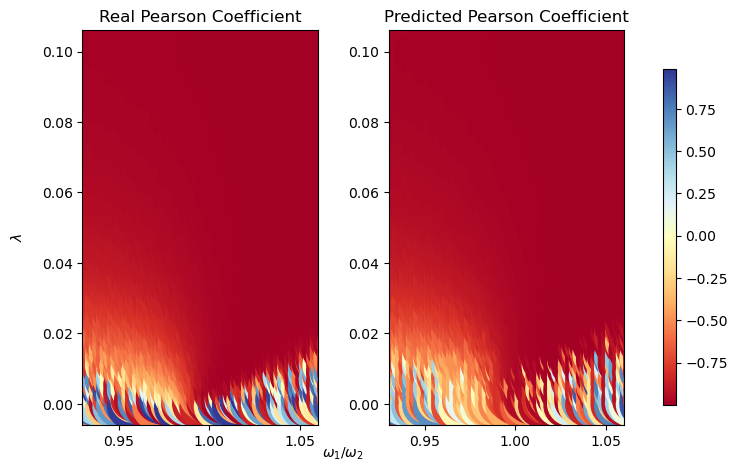

In [19]:
plot_Global_newNet(dataGlobalModel, dataGlobalModel2, meas=100)